94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
🌀 Phase 1: Training top layers only...
Epoch 1/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 68s 19ms/step - accuracy: 0.7261 - loss: 0.8889 - val_accuracy: 0.8550 - val_loss: 0.4168 - learning_rate: 0.0010
Epoch 2/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - accuracy: 0.8066 - loss: 0.5848 - val_accuracy: 0.8632 - val_loss: 0.4003 - learning_rate: 0.0010
Epoch 3/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8229 - loss: 0.5378 - val_accuracy: 0.8766 - val_loss: 0.3553 - learning_rate: 0.0010
Epoch 4/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 0.8335 - loss: 0.5028 - val_accuracy: 0.8818 - val_loss: 0.3417 - learning_rate: 0.0010
Epoch 5/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.8392 - loss: 0.4849 - val_accuracy: 0.8858 - val_loss: 0.3366 - learning_rate: 0.0010
Epoch 6/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8468 - loss: 0.4632 - val_accuracy: 0.8944 - val_loss: 0.3229 - l

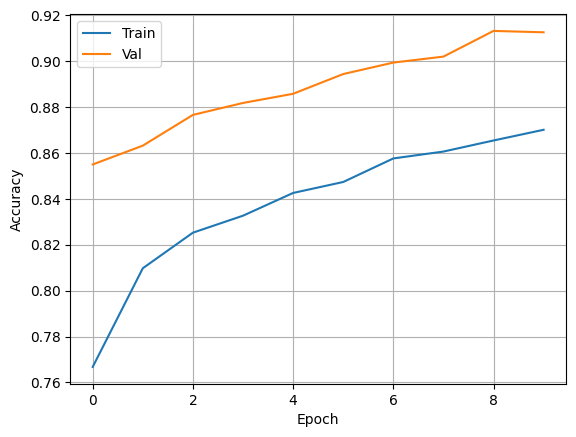

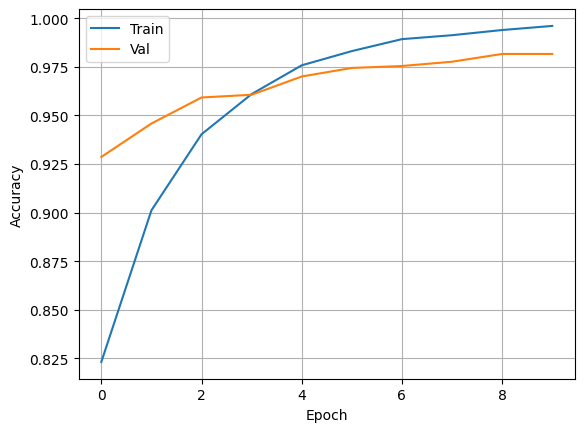

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
# Import preprocess_input specifically from the resnet50 module
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

# Setup mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# Load CIFAR-10 as tf.data.Dataset
def preprocess(image, label):
    image = tf.image.resize(image, (96, 96))
    # The preprocess_input function is now correctly imported
    image = preprocess_input(image)
    return image, label

def get_datasets():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    y_train, y_test = y_train.flatten(), y_test.flatten()

    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

    val_size = int(len(x_train) * 0.1)
    train_ds = train_ds.shuffle(50000)
    val_ds = train_ds.take(val_size)
    train_ds = train_ds.skip(val_size)

    train_ds = train_ds.map(preprocess).batch(16).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(preprocess).batch(16).cache().prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess).batch(16).cache().prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

# Model with Functional API (better memory handling)
def build_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    base_model.trainable = False

    inputs = layers.Input(shape=(96, 96, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax', dtype='float32')(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base_model

# Plotting
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

# Full training routine
def train():
    train_ds, val_ds, test_ds = get_datasets()
    model, base_model = build_model()

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print("🌀 Phase 1: Training top layers only...")
    history1 = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=10,
                         callbacks=[
                             EarlyStopping(patience=4, restore_best_weights=True),
                             ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
                         ])

    # Unfreeze top ResNet layers for fine-tuning
    print("🌀 Phase 2: Fine-tuning deeper layers...")
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history2 = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=10,
                         callbacks=[
                             EarlyStopping(patience=4, restore_best_weights=True),
                             ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
                         ])

    # Evaluate
    loss, acc = model.evaluate(test_ds)
    print(f"\n✅ Final Test Accuracy: {acc * 100:.2f}%")

    plot_history(history1)
    plot_history(history2)

# Run
if __name__ == "__main__":
    train()